In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import mysql.connector
from mysql.connector import errorcode
from urllib.parse import quote_plus
from sqlalchemy import create_engine

In [3]:
config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'Physic955',
    'database': 'Basketball_Reference'
}

password = quote_plus("Physic955")
engine = create_engine(
    f"mysql+mysqlconnector://{config['user']}:{password}@{config['host']}/{config['database']}"
)

In [26]:
query = """
SELECT 
    p.Name,
    p.Experience,
    ROUND(DATEDIFF(DATE(CONCAT('20', RIGHT(s.Season, 2), '-06-30')), p.Birth_date) / 365.25, 1) AS Age_then,
    CASE 
        WHEN p.Experience >= (2025 - (2000 + CAST(RIGHT(s.Season, 2) AS UNSIGNED))) 
        THEN p.Experience - (2025 - (2000 + CAST(RIGHT(s.Season, 2) AS UNSIGNED)))
        ELSE 0
    END AS Exp_then,
    CASE 
        WHEN ROUND(DATEDIFF(DATE(CONCAT('20', RIGHT(s.Season, 2), '-06-30')), p.Birth_date) / 365.25, 1) > 0 
        AND p.Experience >= (2025 - (2000 + CAST(RIGHT(s.Season, 2) AS UNSIGNED)))
        THEN (p.Experience - (2025 - (2000 + CAST(RIGHT(s.Season, 2) AS UNSIGNED)))) / 
             ROUND(DATEDIFF(DATE(CONCAT('20', RIGHT(s.Season, 2), '-06-30')), p.Birth_date) / 365.25, 1)
        ELSE NULL
    END AS Skill,
    s.Season,
    CASE 
        WHEN s.Season IN ('2022-23', '2023-24') THEN 'جدید'
        ELSE 'قدیم'
    END AS Period
FROM champion_players cp
JOIN players p ON cp.PlayerID = p.PlayerID
JOIN seasons s ON cp.SeasonID = s.SeasonID
WHERE s.Season IN ('2020-21', '2021-22', '2022-23', '2023-24')
    AND p.Birth_date IS NOT NULL
    AND p.Experience IS NOT NULL
    AND DATEDIFF(DATE(CONCAT('20', RIGHT(s.Season, 2), '-06-30')), p.Birth_date) > 0
ORDER BY Period, s.Season, Skill DESC;
"""


skill = pd.read_sql(query, engine)

skill = skill.dropna(subset=['Skill'])

old_period = skill[skill['Period'] == 'قدیم']['Skill'].values
new_period = skill[skill['Period'] == 'جدید']['Skill'].values

In [27]:
print('old period')
print("\n")
print(pd.Series(old_period).describe())
print("\n")
print("\n")
print('new period')
print("\n")
print(pd.Series(new_period).describe())

old period


count    35.000000
mean      0.181280
std       0.126906
min       0.000000
25%       0.068750
50%       0.134700
75%       0.285400
max       0.416700
dtype: float64




new period


count    37.000000
mean      0.203214
std       0.122758
min       0.000000
25%       0.114500
50%       0.185900
75%       0.281700
max       0.446200
dtype: float64


In [29]:
shapiro_old = stats.shapiro(old_period)
shapiro_new = stats.shapiro(new_period)
print(f"\nShapiro-Wilk Test for Normality - Old Period: statistic={shapiro_old.statistic:.4f}, p-value={shapiro_old.pvalue:.4f}")
print(f"Shapiro-Wilk Test for Normality - New Period: statistic={shapiro_new.statistic:.4f}, p-value={shapiro_new.pvalue:.4f}")


Shapiro-Wilk Test for Normality - Old Period: statistic=0.9312, p-value=0.0305
Shapiro-Wilk Test for Normality - New Period: statistic=0.9561, p-value=0.1521


<div style="font-family:Tahoma, sans-serif; direction:rtl; line-height:1.8; font-size:17px; text-align:justify; padding:12px; border:1px solid #ddd; border-radius:8px; box-sizing:border-box; max-width:100%; margin:0 auto;">
  <p>
    p-value (0.0305) کمتر از 0.05 هست. این یعنی با 95% اطمینان فرض صفر (نرمال بودن) رد می‌شه. 
    <br><b>نتیجه:</b> داده‌های دوره قدیم (2020-21 و 2021-22) به‌طور آماری غیرنرمالن. این می‌تونه به‌خاطر وجود اوت‌لایرها (مثلاً بازیکنان خیلی جوان یا خیلی با تجربه) 
  </p>
  <p>
    p-value (0.1521) بیشتر از 0.05 هست. این یعنی با 95% اطمینان نمی‌تونیم فرض صفر (نرمال بودن) رو رد کنیم. 
    <br><b>نتیجه:</b> داده‌های دوره جدید (2022-23 و 2023-24) به‌طور آماری نرمال به نظر می‌رسن. این برای تست‌های پارامتریک مثل t-test مناسبه، اما چون دوره قدیم غیرنرماله، بهتره از روش‌های غیرپارامتریک برای مقایسه دو دوره استفاده کنیم تا نتیجه دقیق‌تر باشه.
  </p>
</div>

In [ ]:
# H0 = تفاوتی وجود نداره

t_stat, p_value = stats.mannwhitneyu(new_period, old_period, alternative='greater')

print("mann_whitney test result: ")
print("\n")
print(f"U-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

mann_whitney test result: 


U-statistic: 720.5000
p-value: 0.2070


<div style="font-family:Tahoma, sans-serif; direction:rtl; line-height:1.8; font-size:17px; text-align:justify; padding:12px; border:1px solid #ddd; border-radius:8px; box-sizing:border-box; max-width:100%; margin:0 auto;">
  <p>
    مقدار U-statistic (720.5000) نشان‌دهنده تفاوت متوسط در رتبه‌بندی‌های توانایی ذاتی (Skill) بین دو دوره است، اما این مقدار نسبتاً بالاست، که نشان‌دهنده تفاوت کم بین دوره جدید و قدیم است.
  </p>
  <p>
    p-value (0.2070) که بیشتر از 0.05 است، بیانگر این است که با 95% اطمینان نمی‌توان فرض صفر (H0: μnew ≤ μold) را رد کرد.
  </p>
  <p>
    این یعنی شواهد آماری کافی برای تأیید ادعای افزایش معنادار توانایی ذاتی (Skill) در فصول جدید (2022-23 و 2023-24) نسبت به فصول قدیم (2020-21 و 2021-22) وجود ندارد.
  </p>
  <p>
    اختلاف میانگین Skill (0.203 در مقابل 0.181، یعنی 0.022) بسیار کوچک است و به نظر می‌رسد تحت تأثیر پراکندگی داده‌ها (انحراف معیار حدود 0.123 تا 0.127) یا نویز تصادفی قرار گرفته است.
  </p>
</div>

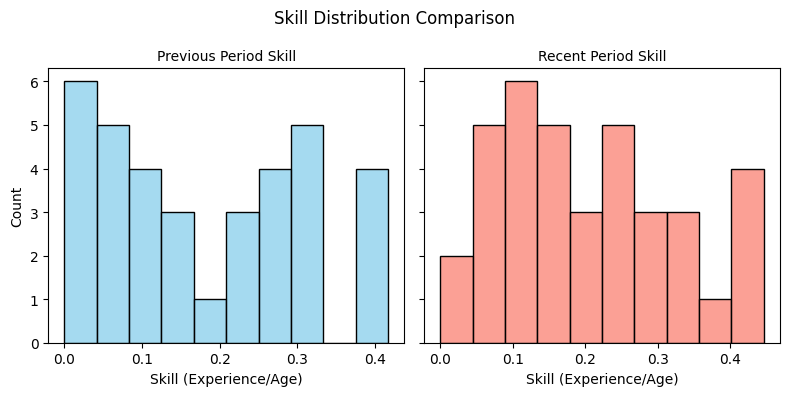

C:\Users\Asus\AppData\Local\Temp\ipykernel_4684\2035109828.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_skill, x='Group', y='Skill', palette=['skyblue', 'salmon'], width=0.5)


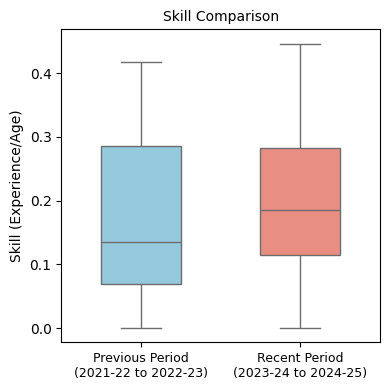

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
sns.histplot(old_period, bins=10, color='skyblue', ax=axes[0], kde=False, edgecolor='black')
axes[0].set_title('Previous Period Skill', fontsize=10)
axes[0].set_xlabel('Skill (Experience/Age)')
axes[0].set_ylabel('Count')

sns.histplot(new_period, bins=10, color='salmon', ax=axes[1], kde=False, edgecolor='black')
axes[1].set_title('Recent Period Skill', fontsize=10)
axes[1].set_xlabel('Skill (Experience/Age)')
axes[1].set_ylabel('')

fig.suptitle('Skill Distribution Comparison', fontsize=12)
plt.tight_layout()
plt.savefig('skill_histogram.png')
plt.show()


plt.figure(figsize=(4, 4))
df_skill = pd.DataFrame({
    'Skill': list(old_period) + list(new_period),
    'Group': ['Previous Period'] * len(old_period) + ['Recent Period'] * len(new_period)
})
sns.boxplot(data=df_skill, x='Group', y='Skill', palette=['skyblue', 'salmon'], width=0.5)
plt.title('Skill Comparison', fontsize=10)
plt.ylabel('Skill (Experience/Age)')
plt.xlabel('')
plt.xticks([0, 1], ['Previous Period\n(2021-22 to 2022-23)', 'Recent Period\n(2023-24 to 2024-25)'], fontsize=9)
plt.grid(False)
plt.tight_layout()
plt.savefig('skill_boxplot.png')
plt.show()

<div style="font-family:Tahoma, sans-serif; direction:rtl; line-height:1.8; font-size:17px; text-align:justify; padding:12px; border:1px solid #ddd; border-radius:8px; box-sizing:border-box; max-width:100%; margin:0 auto;">
  <p>
    <b>تفسیر هیستوگرام (Skill Distribution Comparison):</b> هر دو دوره (قدیم: 2020-21 و 2021-22، جدید: 2022-23 و 2023-24) توزیع مشابهی دارن، با اوج بین 0.1 تا 0.2. دوره جدید یه کم به سمت Skill بالاتر شیفت کرده (میانگین 0.203 vs 0.181)، ولی هم‌پوشانی زیاده و تفاوت چشمگیری نیست.
  </p>
  <p>
    <b>تفسیر باکس‌پلات (Skill Comparison):</b> میانه Skill تو دوره جدید (حدود 0.19) کمی از قدیم (حدود 0.13) بیشتره، ولی جعبه‌ها نزدیک و پراکندگی مشابهه. چند اوت‌لایر (مثلاً بالای 0.4) تو هر دو دوره هست که نشون‌دهنده بازیکنای خاصه.
  </p>
  <p>
    <b>نتیجه کلی:</b> این نمودارها با تست Mann-Whitney U (p-value=0.2070) جور درمیان که فرضیه افزایش توانایی ذاتی تو فصول جدید رد می‌شه. اختلاف کوچیک میانگین (0.022) به نظر تصادفی و تحت تأثیر پراکندگی داده‌هاست.
  </p>
</div>